# 3er entrega - Sistemas de recomendación

En esta entrega vamos a trabajar con un sistema de recomendación.

Vamos a aprovechar la competencia de Telecom que vimos ya que los datos son reales y están buenos para practicar.

En el siguiente repositorio pueden encontrar el significado de cada columna de los datasets:
https://github.com/Datathon2021/Recomendador

Consigna:

- Dividir set en train y test. Tomar como train los datos hasta el 1 de marzo de 2021. Desde el 1ro de marzo en adelante, reservar para test.
- Desarrollar un recomendador. El recomendador debe ser capaz de generar recomendaciones para TODOS los usuarios (incluyendo los cold start que no tengan visualizaciones en el set de train). Generar 20 recomendaciones por usuario.
- Las recomendaciones tienen que ser para cada account_id y hay que recomendar content_id (NO asset_id). Pueden encontrar esto en el repositorio de la competencia.
- Los contenidos que recomienden, no tienen que haber sido vistos previamente por los usuarios (filtrar).
- Evaluarlo con MAP.

Recomendaciones:
- En este caso no tenemos ratings explícitos como los casos que vimos, deben generar ustedes estos ratings mediante algún criterio. Lo más simple podría ser utilizar ratings binarios (lo vió / no lo vió).
- Hay una columna que nos indica hasta cuando va a estar disponible el contenido
- La columna **end_vod_date**: "fecha de finalización de la disponibilidad del activo en la plataforma" puede llegar a serles muy útil. ¿Tiene sentido recomendar algo que no va a estar disponible en el set de test? (a partir del 1 de marzo de 2021).
- Comiencen con algo SIMPLE. No se compliquen con todas las columnas que tiene el dataset. No van a necesitar usar todas, muchas columnas podrán descartarlas dependiendo del enfoque que tomen.

Datos:
- https://drive.google.com/file/d/1QjbqJvU0PTClEhReOyzr96BS-HpyyUKT/view?usp=sharing
- https://drive.google.com/file/d/1ih6SZc44w8FXdFKQJ2l-aqEWFpfceGuN/view?usp=sharing

Fecha de entrega: **30 de Enero de 2023**.

Subir a un repositorio de github (público) y enviar el link a alexispacek@gmail.com. De paso les sirve para ir armando su perfil de github con algunos proyectos 😉.



# Nueva sección

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Los de siempre
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# datetime
from datetime import datetime

# matrices
from scipy.sparse import csr_matrix

# models
from lightfm import LightFM
from tqdm import tqdm
# from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.svm import SVC

# # classifiers
# from sklearn.ensemble import RandomForestClassifier

# # metrics
# from sklearn.metrics import accuracy_score, plot_confusion_matrix
# from sklearn.metrics import  classification_report, confusion_matrix, ConfusionMatrixDisplay

Si hay problemas con la instalación de lightfm, abrir consola de conda y ejecutar lo siguiente:

In [ ]:
conda install -c conda-forge lightfm

Seteamos max_coldwidth

In [ ]:
pd.options.display.max_colwidth = 10000

Leemos los csv

In [5]:
# df_train = pd.read_csv('/content/drive/MyDrive/Cursos/Especializacion en Data Science/Sprint 3/train.csv', delimiter=',')
df_train = pd.read_csv('c:/Users/Asus/Downloads/Curso Data Science - 2022/Cuarto Trabajo/data/train.csv', delimiter=',')
df_train.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0
3,1,3387,STB,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,1
4,1,3387,STB,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,0


In [6]:
# df_metadatos = pd.read_csv('/content/drive/MyDrive/Cursos/Especializacion en Data Science/Sprint 3/metadata.csv', delimiter=';')
df_metadatos = pd.read_csv('c:/Users/Asus/Downloads/Curso Data Science - 2022/Cuarto Trabajo/data/metadata.csv', delimiter=';')
df_metadatos.head()

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",...,N,N,N,N,N,N,2017-12-01T10:18:15.0Z,2019-01-26T06:37:18.0Z,2017-12-01T00:00:00.0Z,2020-12-01T23:59:59.0Z
1,24940,1.0,7 Cajas,7_Cajas,NaN,Película,2012.0,PY,Suspenso/Acción,"Latinoamérica,Pobreza,Crimen,Pandillas",...,N,N,N,Y,N,N,2017-12-19T20:58:15.0Z,2019-09-17T19:02:03.0Z,2017-12-15T00:00:00.0Z,2022-12-14T23:59:59.0Z
2,21939,2.0,La Maldición de las Hormigas Gigantes,La_Maldicion_de_las,NaN,Película,2016.0,FI,Terror/Comedia,"Criaturas,Plagas,Adolescentes,Fantasía,Video J...",...,N,N,N,N,N,N,2018-02-16T13:51:07.0Z,2020-04-28T14:16:38.0Z,2018-01-25T00:00:00.0Z,2020-12-01T23:59:59.0Z
3,9005,3.0,Una Mujer Fantástica,Una_Mujer_Fantastic,NaN,Película,2017.0,CL,Drama,"LGBT,Mujeres,Latinoamérica",...,N,N,N,N,Y,N,2018-05-26T11:58:44.0Z,2019-11-15T03:00:23.0Z,2018-05-27T00:00:00.0Z,2021-04-30T23:59:59.0Z
4,7391,4.0,Star Trek,Star_Trek,NaN,Película,2009.0,US,Ciencia Ficción/Aventura,"Fantasía,Galaxia,Futurismo,Aliens,Criaturas",...,N,N,N,Y,N,N,2019-05-03T20:07:24.0Z,2020-04-09T04:37:29.0Z,2019-05-02T00:00:00.0Z,2020-12-31T23:59:59.0Z


In [7]:
df_train.shape

(3657801, 7)

In [9]:
df_train.account_id.nunique()

113881

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657801 entries, 0 to 3657800
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  int64  
 1   account_id   int64  
 2   device_type  object 
 3   asset_id     float64
 4   tunein       object 
 5   tuneout      object 
 6   resume       int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 195.3+ MB


In [11]:
df_metadatos.shape

(33144, 30)

In [12]:
df_metadatos.asset_id.nunique()

33144

In [13]:
df_metadatos.content_id.nunique()

4366

In [14]:
df_metadatos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33144 entries, 0 to 33143
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   asset_id            33144 non-null  int64  
 1   content_id          33123 non-null  float64
 2   title               33144 non-null  object 
 3   reduced_title       33144 non-null  object 
 4   episode_title       28997 non-null  object 
 5   show_type           33140 non-null  object 
 6   released_year       33144 non-null  float64
 7   country_of_origin   33140 non-null  object 
 8   category            33144 non-null  object 
 9   keywords            33142 non-null  object 
 10  description         33142 non-null  object 
 11  reduced_desc        33144 non-null  object 
 12  cast_first_name     24412 non-null  object 
 13  credits_first_name  20590 non-null  object 
 14  run_time_min        33144 non-null  float64
 15  audience            33143 non-null  object 
 16  made

In [15]:
df_train.isna().sum()

customer_id     0
account_id      0
device_type    29
asset_id       22
tunein          0
tuneout         0
resume          0
dtype: int64

In [ ]:
df_metadatos.isna().sum()

asset_id                  0
content_id               21
title                     0
reduced_title             0
episode_title          4147
show_type                 4
released_year             0
country_of_origin         4
category                  0
keywords                  2
description               2
reduced_desc              0
cast_first_name        8732
credits_first_name    12554
run_time_min              0
audience                  1
made_for_tv               0
close_caption             0
sex_rating                0
violence_rating           0
language_rating           0
dialog_rating             0
fv_rating                 0
pay_per_view              0
pack_premium_1            0
pack_premium_2            0
create_date               0
modify_date               0
start_vod_date            0
end_vod_date              0
dtype: int64

Convertimos 'tunein' a YYYYmmDD, ya que lo utilizaremos para hacer el split para train y test

In [16]:
df_train['timestamp'] = pd.to_datetime(df_train['tunein'], format='%Y/%m/%d')
df_train['timestamp'] = df_train['timestamp'].dt.strftime('%Y/%m/%d')
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'], format='%Y/%m/%d')
df_train.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,timestamp
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0,2021-02-18
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0,2021-03-24
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0,2021-03-15
3,1,3387,STB,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,1,2021-03-15
4,1,3387,STB,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,0,2021-03-16


Fecha mínima y máxima del dataset

In [ ]:
df_train.timestamp.min()

Timestamp('2021-01-01 00:00:00')

In [ ]:
df_train.timestamp.max()

Timestamp('2021-03-31 00:00:00')

Ploteamos la cantidad de reviews por año:

In [ ]:
plot_df = df_train.copy()
plot_df["year"] = df_train.timestamp.dt.year
plot_df = plot_df.groupby("year", as_index=False).count()[["year", "customer_id"]]
plot_df.columns = ["year", "reviews_count"]
plot_df.head()

,year,reviews_count
0,2021,3657801


Ploteamos la cantidad de reviews por mes:

In [ ]:
plot_df = df_train.copy()
plot_df["month"] = df_train.timestamp.dt.month
plot_df = plot_df.groupby("month", as_index=False).count()[["month", "customer_id"]]
plot_df.columns = ["month", "reviews_count"]
plot_df.head()

,month,reviews_count
0,1,1216469
1,2,1122595
2,3,1318737


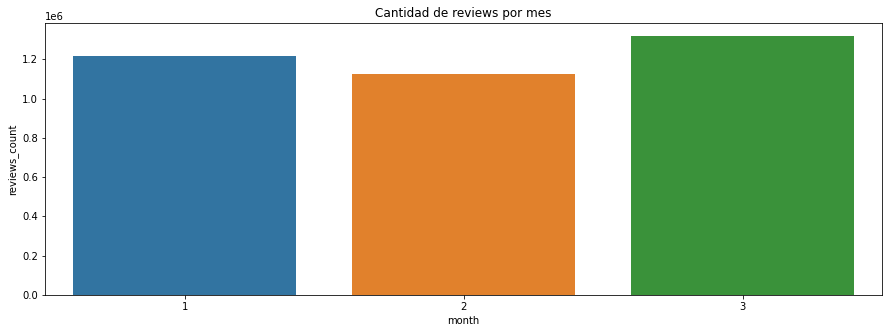

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x=plot_df.month, y=plot_df.reviews_count)
plt.title("Cantidad de reviews por mes")
plt.show()

Empezamos con el rating

según la profe: sumamos los tiempos (accountid y contentid) y luego los dropeamos

In [17]:
df_train['from'] =  pd.to_datetime(df_train['tunein'], format='%Y-%m-%d %H:%M:%S.%f')

In [18]:
df_train['to'] =  pd.to_datetime(df_train['tuneout'], format='%Y-%m-%d %H:%M:%S.%f')

In [21]:
df_train['resultado'] = df_train['to']-df_train['from']
df_train.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,timestamp,from,to,resultado,minutos
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0,2021-02-18,2021-02-18 22:52:00,2021-02-18 23:35:00,0 days 00:43:00,43.0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0,2021-03-24,2021-03-24 23:17:00,2021-03-25 00:01:00,0 days 00:44:00,44.0
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0,2021-03-15,2021-03-15 10:05:00,2021-03-15 10:23:00,0 days 00:18:00,18.0
3,1,3387,STB,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,1,2021-03-15,2021-03-15 10:23:00,2021-03-15 11:18:00,0 days 00:55:00,55.0
4,1,3387,STB,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,0,2021-03-16,2021-03-16 09:24:00,2021-03-16 09:44:00,0 days 00:20:00,20.0


In [22]:
# Minutos vistos por el usuario
df_train['minutos'] = df_train['resultado'].dt.seconds.div(60).astype(float) 
df_train.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,timestamp,from,to,resultado,minutos
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0,2021-02-18,2021-02-18 22:52:00,2021-02-18 23:35:00,0 days 00:43:00,43.0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0,2021-03-24,2021-03-24 23:17:00,2021-03-25 00:01:00,0 days 00:44:00,44.0
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0,2021-03-15,2021-03-15 10:05:00,2021-03-15 10:23:00,0 days 00:18:00,18.0
3,1,3387,STB,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,1,2021-03-15,2021-03-15 10:23:00,2021-03-15 11:18:00,0 days 00:55:00,55.0
4,1,3387,STB,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,0,2021-03-16,2021-03-16 09:24:00,2021-03-16 09:44:00,0 days 00:20:00,20.0


In [ ]:
# Esta columna contiene la duración de la pelicula
df_metadatos['run_time_min']

0         48.0
1        105.0
2         82.0
3         99.0
4        126.0
         ...  
33139     64.0
33140     56.0
33141     24.0
33142     42.0
33143     11.0
Name: run_time_min, Length: 33144, dtype: float64

In [23]:
# duración minima
df_metadatos['run_time_min'].min()

0.0

In [30]:
# Cuantos items hay con duración 0
df_metadatos[df_metadatos['run_time_min'] <= 0.0]['run_time_min'].count()

117

In [ ]:
# duracion máxima
df_metadatos['run_time_min'].max()

308.0

Dropeamos lo que no nos sirve

In [31]:
df_train.drop(['device_type','resume','from','to','resultado'],axis=1, inplace=True)

In [32]:
df_metadatos_mini = df_metadatos[['asset_id', 'content_id','title','run_time_min','start_vod_date','end_vod_date']].copy()

Mergeamos los dos datasets a partir del campo asset_id

In [33]:
df_map = df_train.merge(df_metadatos_mini, how="left", left_on="asset_id", right_on="asset_id")
df_map.head()

,customer_id,account_id,asset_id,tunein,tuneout,timestamp,minutos,content_id,title,run_time_min,start_vod_date,end_vod_date
0,0,90627,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,2021-02-18,43.0,2040.0,T:5 Ep:08 This is Us,43.0,2021-02-18T00:00:00.0Z,2021-06-30T23:59:59.0Z
1,0,90627,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,2021-03-24,44.0,2040.0,T:5 Ep:10 This is Us,42.0,2021-03-18T00:00:00.0Z,2021-06-30T23:59:59.0Z
2,1,3387,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,2021-03-15,18.0,1983.0,T:1 Ep:02 Big Little Lies,54.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z
3,1,3387,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,2021-03-15,55.0,1983.0,T:1 Ep:02 Big Little Lies,54.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z
4,1,3387,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,2021-03-16,20.0,729.0,T:1 Ep:02 Dime quién soy,49.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z


In [34]:
df_map['minutos_vistos'] = df_map['run_time_min'] - df_map['minutos']

In [35]:
df_map['porcentaje_visto'] = df_map['minutos'] * 100 / df_map['run_time_min']


In [36]:
df_map[df_map['minutos_vistos'] < 0].count()[1]

535905

In [37]:
df_map[df_map['minutos_vistos'] < 0].count()[1] * 100 / df_map.shape[0]

14.651015733223321

Creando el rating

In [38]:
df_map['rating'] = df_map['porcentaje_visto'].apply(lambda x : 1 if x >= 50 else 0)
df_map.head()

,customer_id,account_id,asset_id,tunein,tuneout,timestamp,minutos,content_id,title,run_time_min,start_vod_date,end_vod_date,minutos_vistos,porcentaje_visto,rating
0,0,90627,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,2021-02-18,43.0,2040.0,T:5 Ep:08 This is Us,43.0,2021-02-18T00:00:00.0Z,2021-06-30T23:59:59.0Z,0.0,100.000000,1
1,0,90627,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,2021-03-24,44.0,2040.0,T:5 Ep:10 This is Us,42.0,2021-03-18T00:00:00.0Z,2021-06-30T23:59:59.0Z,-2.0,104.761905,1
2,1,3387,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,2021-03-15,18.0,1983.0,T:1 Ep:02 Big Little Lies,54.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,36.0,33.333333,0
3,1,3387,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,2021-03-15,55.0,1983.0,T:1 Ep:02 Big Little Lies,54.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,-1.0,101.851852,1
4,1,3387,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,2021-03-16,20.0,729.0,T:1 Ep:02 Dime quién soy,49.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,29.0,40.816327,0


Train y Test

In [39]:
ratings = df_map.copy()
ratings.head()

,customer_id,account_id,asset_id,tunein,tuneout,timestamp,minutos,content_id,title,run_time_min,start_vod_date,end_vod_date,minutos_vistos,porcentaje_visto,rating
0,0,90627,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,2021-02-18,43.0,2040.0,T:5 Ep:08 This is Us,43.0,2021-02-18T00:00:00.0Z,2021-06-30T23:59:59.0Z,0.0,100.000000,1
1,0,90627,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,2021-03-24,44.0,2040.0,T:5 Ep:10 This is Us,42.0,2021-03-18T00:00:00.0Z,2021-06-30T23:59:59.0Z,-2.0,104.761905,1
2,1,3387,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,2021-03-15,18.0,1983.0,T:1 Ep:02 Big Little Lies,54.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,36.0,33.333333,0
3,1,3387,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,2021-03-15,55.0,1983.0,T:1 Ep:02 Big Little Lies,54.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,-1.0,101.851852,1
4,1,3387,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,2021-03-16,20.0,729.0,T:1 Ep:02 Dime quién soy,49.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,29.0,40.816327,0


In [41]:
# ratings.drop(['customer_id','asset_id','tunein','tuneout','minutos','from','to','resultado','title', 'run_time_min', 'start_vod_date', 'end_vod_date', 'minutos_vistos', 'porcentaje_visto'],axis=1, inplace=True)
ratings.drop(['customer_id','asset_id','tunein','tuneout','minutos','title', 'run_time_min', 'start_vod_date', 'end_vod_date', 'minutos_vistos', 'porcentaje_visto'],axis=1, inplace=True)
ratings.head()

,account_id,timestamp,content_id,rating
0,90627,2021-02-18,2040.0,1
1,90627,2021-03-24,2040.0,1
2,3387,2021-03-15,1983.0,0
3,3387,2021-03-15,1983.0,1
4,3387,2021-03-16,729.0,0


In [42]:
# reordeno columnas
ratings = ratings[['account_id', 'content_id', 'rating', 'timestamp']]

In [43]:
# set de train
train = ratings[(ratings.timestamp >= datetime(year=2021, month=1, day=1)) &
                (ratings.timestamp < datetime(year=2021, month=3, day=1))]
train.head()

,account_id,content_id,rating,timestamp
0,90627,2040.0,1,2021-02-18
6,3388,2100.0,0,2021-01-01
7,3388,2100.0,0,2021-01-02
8,3388,2100.0,0,2021-01-02
9,3388,2100.0,0,2021-01-04


In [ ]:
train.shape

(2339064, 4)

In [ ]:
train.account_id.nunique()

99649

In [44]:
# set de test
test = ratings[ratings.timestamp >= datetime(year=2021, month=3, day=1)]
test.head()

,account_id,content_id,rating,timestamp
1,90627,2040.0,1,2021-03-24
2,3387,1983.0,0,2021-03-15
3,3387,1983.0,1,2021-03-15
4,3387,729.0,0,2021-03-16
5,3387,729.0,0,2021-03-16


In [ ]:
test.shape

(1318737, 4)

In [ ]:
test.account_id.nunique()

87635

¿Tenemos usuarios que aparecen en test pero no en train? 

In [45]:
test[~test.account_id.isin(train.account_id.unique())].account_id.nunique()

14232

Como vemos, tenemos este problema. Utilizaremos "cold start" al momento de recomendar a estos usuarios.

Armamos la matriz de interacción.

In [46]:
matrix_columns = ["account_id","content_id", "rating"]

In [47]:
interactions = train[matrix_columns]
interactions.head()

,account_id,content_id,rating
0,90627,2040.0,1
6,3388,2100.0,0
7,3388,2100.0,0
8,3388,2100.0,0
9,3388,2100.0,0


Acá pincho colab..........

In [ ]:
# tarda 15 minutos
# interactions_matrix = pd.pivot(index="account_id", columns="content_id", values="rating")
interactions_matrix = pd.pivot_table(interactions[["account_id","content_id", "rating"]], index='account_id', columns='content_id', values='rating')
interactions_matrix.head() 

Completo los NaN con ceros

In [49]:
interactions_matrix = interactions_matrix.fillna(0)
interactions_matrix.head()

content_id,0.0,1.0,3.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,...,4357.0,4358.0,4359.0,4360.0,4361.0,4362.0,4363.0,4364.0,4365.0,4366.0
account_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


¿Cuántas filas y columnas tiene la matriz de interacción?

In [52]:
interactions_matrix.shape

(99647, 3692)

Generemos diccionarios de usuarios y items

In [74]:
user_id = list(interactions_matrix.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

In [55]:
item_id = list(interactions_matrix.columns)
item_dict = {}
counter = 0 
for i in item_id:
    item_dict[i] = counter
    counter += 1

Transformamos la matriz a csr matrix (compressed sparse row)

In [57]:
interactions_matrix_csr = csr_matrix(interactions_matrix.values)

In [58]:
interactions_matrix_csr.shape

(99647, 3692)

# Modelo

Utilizaremos la librería LFM (light fm) para realizar un modelo de recomendación.

In [59]:
# model = LightFM(no_components=3, random_state=100, learning_rate=0.03)

In [ ]:
model = LightFM(random_state=0,
                loss='warp',
                learning_rate=0.03,
                no_components=100)

Entrenar el modelo con la matriz csr por 10 epochs:

In [60]:
model = model.fit(interactions_matrix_csr, epochs=10)

Probando el modelo para un usuario cualquiera

In [61]:
user_x = user_dict[18]
n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)
#ACA GENERAMOS PREDICCIONES
preds = model.predict(user_ids=user_x, item_ids = item_ids)

Este array que obtenemos son los scores que le da el modelo a cada item para el usuario 18. Podemos ordenarlo y obtener las mejores recomendaciones

In [62]:
scores = pd.Series(preds)
scores.index = interactions_matrix.columns
recomms_18 = list(pd.Series(scores.sort_values(ascending=False).index))[:10] #obtenemos las primeras 10

In [63]:
recomms_18

[2040.0, 3900.0, 3806.0, 2160.0, 1316.0, 116.0, 2627.0, 1462.0, 1139.0, 3726.0]

Popularidad de contenido para cold start

In [64]:
popularity_df = train.groupby("content_id", as_index=False).agg({"account_id":"nunique"}).sort_values(by="account_id", ascending=False)

popularity_df.columns=["content_id", "popularity"]
popularity_df.head()

,content_id,popularity
1733,2040.0,11481
3478,3806.0,8762
3572,3900.0,7960
3274,3598.0,3772
1851,2160.0,3506


In [65]:
popularity_df.head(10).content_id.values

array([2040., 3806., 3900., 3598., 2160., 3381., 1462., 3690., 3210.,
       3550.])

Creando nuestra función de recomendación

In [66]:
def recomm(model, interactions, user_id, user_dict, item_dict, nrec_items = 10, show = True):
"""
    n_users, n_items = interactions_matrix.shape
    user_x = user_dict[user_id]

    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions_matrix.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions_matrix.loc[user_id,:] \
                                [interactions_matrix.loc[user_id,:] > 0].index).sort_values(ascending=False))
    
    #Filtro de items que ya leyó el usuario
    scores = [x for x in scores if x not in known_items]
    recomms = scores[0:nrec_items]

    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + str(i))
            counter+=1

        print("\n Recommended Items:")
        
        counter = 1
        for i in recomms:
            print(str(counter) + '- ' + str(i))
            counter+=1
    return recomms
"""

Ya tenemos la función de recomendaciones. La probamos

In [67]:
# recomms_df = pd.DataFrame(recomms_dict)
# recomms_df
"""
recomms_test = recomm(model, interactions_matrix_csr, 18, user_dict, item_dict, show=True)
"""

User: 18
Known Likes:
1- 3064.0
2- 1314.0

 Recommended Items:
1- 2040.0
2- 3900.0
3- 3806.0
4- 2160.0
5- 1316.0
6- 116.0
7- 2627.0
8- 1462.0
9- 1139.0
10- 3726.0


# Ahora obtenemos las recomendaciones para todos los usuarios

Primero comenzamos armando un listado de usuarios "non cold" a los cuales les daremos recomms personalizadas.

In [68]:
# Todos lo usuarios
users = df_map.account_id.unique() 
# Usuarios no cold
non_cold_users = train.account_id.unique()

print(len(users), len(non_cold_users))

113881 99649


In [83]:
from tqdm import tqdm

#definimos dict donde vamos a ir almacenando las recomendaciones
recomms_dict = {
    'user_id': [],
    'recomms': [],
    'cold': []
}

#obtenemos cantidad de usuarios y cantidad de items
n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)

#por cada usuario del dataset completo, generamos recomendaciones
for user in tqdm(df_map.account_id.unique()): ### CUIDADO: USAR TEST - test.account_id.unique()
    #COMPLETAR: Validar si el usuario se encuentra en la matriz de interacciones (interactions_matrix.index)
    if user in list(interactions_matrix.index):
      # Si el usuario esta en train, no es cold start. Usamos el modelo para recomendar
      user_x = user_dict[user] #buscamos el indice del usuario en la matriz (transformamos id a indice)

      #COMPLETAR: Generar las predicciones para el usuario x
      preds = model.predict(user_ids=user_x, item_ids = item_ids)

      #COMPLETAR: Basándose en el ejemplo anterior, ordenar las predicciones de menor a mayor y quedarse con 50.
      scores = pd.Series(preds)
      scores.index = interactions_matrix.columns
      scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]

      #COMPLETAR: Obtener listado de contenidos vistos anteriormente por el usuario (en el set de train)
      watched_contents = train[train.account_id == user].content_id.unique()
  
      #COMPLETAR: Filtrar contenidos ya vistos y quedarse con los primeros 10
      recomms = [x for x in scores if x not in watched_contents][:10]

      # Guardamos las recomendaciones en el diccionario
      recomms_dict['user_id'].append(user)
      recomms_dict['recomms'].append(scores)
      recomms_dict['cold'].append(False)
    
    # En este else trataremos a los usuarios que no están en la matriz (cold start)
    else:
      recomms_dict['user_id'].append(user)
      # Les recomendamos contenido popular
      recomms_dict['recomms'].append(popularity_df.content_id.to_list())
      recomms_dict['cold'].append(True)

100%|████████████████████████████████████████████████████████████████████████████| 87635/87635 [43:44<00:00, 33.39it/s]


Este codigo pincha...... hay algo mal en el diccionario, queda fuera de rango...

In [77]:
"""
recomms_dict = {
    "user": [],
    "recomms": [],
    "cold": []
}

for user in users:
  
  # Recomms personalizadas
  if user in non_cold_users:
    user_recomms = recomm(model, interactions_matrix, user, user_dict, item_dict, nrec_items = 10, show = False)
    recomms_dict["user"].append(user)
    recomms_dict["recomms"].append(user_recomms)
    recomms_dict["cold"].append(False) #Para luego tener identificados a los usuarios cold
  
  # Recomms cold
  else:
    recomms_dict["user"].append(user)
    recomms_dict["recomms"].append(popularity_df.content_id.to_list())
    recomms_dict["cold"].append(True) #Para luego tener identificados a los usuarios cold
"""

KeyError: 95749

In [73]:
user_dict[95749]

KeyError: 95749

Ahora tenemos un diccionario de recomedaciones. Lo vamos a convertir en dataframe para poder manipularlo más fácil (como estamos acostumbrados)

In [84]:
recomms_df = pd.DataFrame(recomms_dict)
recomms_df.head()

,user_id,recomms
0,90627,"[2040.0, 3900.0, 3806.0, 2160.0, 1316.0, 116.0..."
1,3387,"[2040.0, 3806.0, 3900.0, 3598.0, 2160.0, 3381...."
2,3388,"[2040.0, 3900.0, 3806.0, 2160.0, 1316.0, 116.0..."
3,3389,"[2040.0, 3900.0, 3806.0, 2160.0, 1316.0, 116.0..."
4,3393,"[2040.0, 3900.0, 3806.0, 2160.0, 1316.0, 116.0..."


In [86]:
recomms_df.user_id.nunique()

87635

In [87]:
recomms_df.cold.value_counts()

AttributeError: 'DataFrame' object has no attribute 'cold'

Ahora tenemos que comparar nuestras recomms contra lo que los usuarios realmente vieron (test).

Primero ordenamos libros según los ratings (mayor a menor) que dieron los usuarios en el set de test.

Luego, agrupamos y armamos un listado de libros para cada usuario.

Este es el listado "ideal" contra el que vamos a comparar nuestras recomendaciones.

In [ ]:
ideal_recomms = test[interactions_test.is_read]\
                  .sort_values(by=["account_id", "rating"], ascending=False)\
                  .groupby(["user_id"], as_index=False)\
                  .agg({"book_id": "unique"})\
                  .head()
ideal_recomms.head()

In [88]:
ideal_recomms = test\
                  .sort_values(by=["account_id", "rating"], ascending=False)\
                  .groupby(["account_id"], as_index=False)\
                  .agg({"content_id": "unique"})\
                  .head()
ideal_recomms.head()

,account_id,content_id
0,2,[433.0]
1,3,"[1949.0, 2409.0, 4010.0, 3169.0, 3487.0, 3980...."
2,4,"[513.0, 2212.0, 565.0, 2314.0, 728.0, 4129.0, ..."
3,5,[2259.0]
4,6,"[3211.0, 2900.0, 4065.0, 3902.0, 3386.0, 3388.0]"


# Métricas

In [89]:
df_map = ideal_recomms.merge(recomms_df, how="left", left_on="account_id", right_on="user_id")[["account_id", "content_id", "recomms"]]
df_map.columns = ["user_id", "ideal", "recomms"]
df_map.head()

,user_id,ideal,recomms
0,2,[433.0],"[2040.0, 3900.0, 3806.0, 2160.0, 1316.0, 116.0..."
1,3,"[1949.0, 2409.0, 4010.0, 3169.0, 3487.0, 3980....","[2040.0, 3900.0, 3806.0, 2160.0, 1316.0, 2627...."
2,4,"[513.0, 2212.0, 565.0, 2314.0, 728.0, 4129.0, ...","[2040.0, 3900.0, 3806.0, 2160.0, 1316.0, 116.0..."
3,5,[2259.0],"[2040.0, 3900.0, 3806.0, 2160.0, 1316.0, 116.0..."
4,6,"[3211.0, 2900.0, 4065.0, 3902.0, 3386.0, 3388.0]","[2040.0, 3900.0, 3806.0, 2160.0, 1316.0, 116.0..."


In [90]:
aps = [] # lista vacía para ir almacenando la AP de cada recomendación

for pred, label in df_map[["ideal", "recomms"]].values:
  n = len(pred) # cantidad de elementos recomendados
  arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1 
  rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
  tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
  denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
  ap = (tp / denom).sum() / len(label) # average precision
  aps.append(ap)

In [91]:
MAP = np.mean(aps)
print(f'mean average precision = {round(MAP, 5)}')

mean average precision = 0.0
